# Телеком — Поиск клиента с неоптимальными тарифами

## Вступление

### Описание проекта

Мы предстаем джуниор-аналитиком в команде сервиса телеком-провайдера. Наши клиенты − колл-центры, мы хотим помочь им найти неэффективных операторов, а также предлагать самые выгодные тарифы, чтобы клиент долго жил с нами и не переплачивал

### Цель проекта

Узнать на полученных данных, кто из клиентов переплачивает и кого можно перевести на более выгодные тарифы. 

### Задача проекта

Найти клиентов, которые: 

а) переплачивают на текущих тарифах; 

б) сэкономят, если перейдут на более дорогой тариф.


### План проекта

- Изучим и проверим данные:
    - Загрузим данные и подготовим их к исследованию
    - Посмотрим на датасет: есть ли в нём отсутствующие значения (пропуски), изучим средние значения и стандартные отклонения;
    - Переименуем столбцы и изменим типы данных если того требует задача
    - Проверим датасет на ошибки и аномалии;
- Проведем исследовательский анализ данных:
    - Проанализируем общее количество клиентов;
    - Посчитаем для каждого пользователя количество сделанных звонков и количество потраченных минут в разрезе месяца и за весь изучаемый период;
    - Проверим наличие "выбивающихся" из общего потока пользователей и выдвинем предположение о причине появления таких пользователей.
    - Рассчитаем общую выручку в разрезе месяца и за весь изучаемый период
    - Рассчитаем LTV (life time value) каждого пользователя для нашего клиента - а именно, сколько денег принес каждый клиент в разрезе месяца/всего изучаемого периода
    - Рассмотрим параметры выбора активных клиентов;
    - Проведем поиск клиентов с неоптимальными тарифами (тех, кто мог бы платить меньше)
    - Изучим возможные потери в выручке при переводе клиентов находящися на неоптимальных тарифах при переводе их на оптимальные.
    - Выдвинем предположение: "как уменьшить риск падения выручки, если все клиенты перейдут на более выгодные тарифы?" и оценим возможные сроки возврата на предыдущие значения по выручкам.
- Сформулируем и проверим статистические гипотезы по которым можно сделать полезные выводы для бизнеса:
1. Средняя выручка клиента до перевода на оптимальные тарифы отличается от выручки после перевода на оптимальные тарифы.
~~2. Средняя выручка клиента не изменится при переводе клиентов на посекундную тарификацию~~
_Данная теория оказалась неприменима к нашему датасету так как в следствии анализа мы убедились в том, что данные представлены в минутах и уже округлены, в связи с чем проверка такой гипотезы не имеет логического смысла_

2.  Средняя выручка заказчика изменится при изменении абонентской платы у тарифных планов

- Сформулируем выводы и сделаем базовые рекомендации уменьшению потерь в выручках и скорейшему выходу на прежние значения и рост.
    
### Описание данных

#### Правила формирования тарифов:

Ежемесячная плата за тариф:

- Тариф А — 5000 ₽,
- B — 2000 ₽,
- С — 1000 ₽.

**Входящие звонки** — бесплатны на всех тарифах,

**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.4 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7 ₽/мин.

За каждого оператора клиент платит 100 ₽ в месяц на любом тарифе — дополнительно к стоимости тарифа и цене звонков.

#### Описание данных в датасетах

**Датасет `telecom_dataset`** 

- `user_id` — идентификатор клиента;
- `date` — дата статистики;
- `direction` — направление вызовов: `out` — исходящий вызов, `in` — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность звонка без учёта времени ожидания;
- `total_call_duration` — длительность звонка с учётом времени ожидания.

**Датасет `telecom_clients`**

- `user_id` — идентификатор клиента;
- `tariff_plan` — тарифный план клиента;
- `date_start` — дата регистрации клиента в сервисе.

## Тело проекта

### Настроим необходимое в работе окружение

In [1]:
import pandas as pd # Импортируем библиотеку pandas для работы с таблицами
import numpy as np # для работы с массивами данных
from scipy import stats as st # для работы со статистикой
import matplotlib.pyplot as plt # Для работы с визуализацией данных 
import seaborn as sns
import warnings # Отключим предупреждения платформы
warnings.simplefilter('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5 # Сразу установим увеличенный дефолтный размер графиков
from functools import reduce #для корректного объединения таблиц

### Загрузка и изучение данных



In [2]:
try:
    telecom_clients = pd.read_csv('/datasets/telecom_clients.csv') # для открытия в ЯП
    telecom_dataset = pd.read_csv('/datasets/telecom_dataset.csv')
except:
    telecom_clients = pd.read_csv('/work/telecom_clients.csv')  # я работаю в DeepNote ^_^
    telecom_dataset = pd.read_csv('/work/telecom_dataset.csv')
    # выведем датасеты для первичного ознакомления а также познакомимся с его характеристиками

print('таблица telecom_clients')
telecom_clients.info()
display(telecom_clients.head())
print('---'*10)
print('таблица telecom_dataset')
telecom_dataset.info()
telecom_dataset.head()

таблица telecom_clients
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


------------------------------
таблица telecom_dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Начнем с таблицы **`telecom_clients`**:
- Изменим тип данных в столбце date_start на datetime
- Убедимся в отсутствии пропущенных значений
- Проверим наличие дубликатов
- Проверим период данных на выбивающиеся значения

In [3]:
telecom_clients['date_start'] = pd.to_datetime(telecom_clients['date_start'], format='%Y-%m-%d')

In [4]:
print(f'Тип данных столбца date_start после изменения {telecom_clients["date_start"].dtype}')
print(f'Выведем количество пропусков по каждому столбцу ниже')
print(telecom_clients.isna().sum())
print('')
print('Количество полных дубликатов в таблице')
print(telecom_clients.duplicated().sum())
print('')
print(f'Дата начала периода {telecom_clients["date_start"].min()}')
print(f'Дата конца периода {telecom_clients["date_start"].max()}')

Тип данных столбца date_start после изменения datetime64[ns]
Выведем количество пропусков по каждому столбцу ниже
user_id        0
tariff_plan    0
date_start     0
dtype: int64

Количество полных дубликатов в таблице
0

Дата начала периода 2019-08-01 00:00:00
Дата конца периода 2019-10-31 00:00:00


__Пропуски и дубликаты отсутствуют__, период данных регистрации клиента составляет с 1-го августа 2019 года по 31-е октября 2019.

Перейдем к таблице **`telecom_dataset`**:
- Изучим наличие и количество пропусков
- Проверим наличие полных дублей в сете
- Изменим типа данных столбца date на datetime
- Изменим тип данных столбца operator_id на int поскольку id опертора не может быть дробным значением
- Проверим насколько данные столбца с датами соответствуют ТЗ 
- Построим гистограммы распределения значений в численных столбцах для предварительного выявления аномалий требующих нашего внимания

In [5]:
print(f'Выведем количество пропусков по каждому столбцу ниже')
print(telecom_dataset.isna().sum())
print('')
print('Количество полных дубликатов в таблице')
print(telecom_dataset.duplicated().sum())
print('')

Выведем количество пропусков по каждому столбцу ниже
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Количество полных дубликатов в таблице
4900



Мы обнаружили __пропуски в столбцах internal и operator_id__, а также __4900 полных дубликатов в столбцах__, необходимо определить долю таких дубликатов и их природу. Выполним данный пункт вне очереди. 


__После обнаружения пропусков в столбце operator_id принимаем тот факт, что изменить тип данных на данном этапе без вмешательства в данные невозможно. В связи с этим пропустим этот этап и вернемся к нему позже.__

In [6]:
print(f'Доля пропущенных значений в столбце internal: {round((telecom_dataset["internal"].isna().sum() / len(telecom_dataset["internal"])*100),2)} %')
telecom_dataset.query('internal.isnull()').head()

Доля пропущенных значений в столбце internal: 0.22 %


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423


По результатам более тщательного рассмотрения данного столбца становится понятно, что:
- Абсолютное большинство (98.3%) данных пропущенных значений приходится на входящие звонки, что означает что такие значения точно не повлияют на ход наших исследований.
- 57 строк из 117 являются также пропусками по столбцам с операторами, к чему мы вернемся позже.
- Доля подобного рода пропусков составляет 0.22% от общего количества данных, в связи с чем мы принимаем решение удалить такие строки, не считая это глобальным вмешательством в данные.

In [7]:
telecom_dataset = telecom_dataset.query('internal.notna()') # оставляет только те строки где есть значения
telecom_dataset.info() # проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53785 non-null  int64  
 1   date                 53785 non-null  object 
 2   direction            53785 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45670 non-null  float64
 5   is_missed_call       53785 non-null  bool   
 6   calls_count          53785 non-null  int64  
 7   call_duration        53785 non-null  int64  
 8   total_call_duration  53785 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


In [8]:
print(f'Доля пропущенных значений в столбце operator_id: {round((telecom_dataset["operator_id"].isna().sum() / len(telecom_dataset["operator_id"])*100),2)} %')
telecom_dataset.query('operator_id.isnull()').head()

Доля пропущенных значений в столбце operator_id: 15.09 %


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34


По пропускам в данном столбце можно сказать следующее:
- Они занимают 15.2% от общего количества данных, что является очень существенным, естественно просто удалить их мы не можем.
- 97.6% таких пропусков это входящие вызовы
- 95.6% таких пропусков это внешние вызовы
- И наконец, 98.5% таких пропусков это пропущенные вызовы! 

Все вышеперечисленные выводы наводят нас на мысль о достаточно четкой закономерности:
1. Происходит внешний входящий звонок пользователю
2. Ответа не Происходит по причине:
    - сброса звонка
    - недозвона
    - технической ошибки
3. Система "не успевает" присвоить оператора и на выходе получается пропущенное значение.

Из чего мы делаем вывод, что для дальнейшего более удобного исследования создать значение заглушку "0",так, мы сможем оставить данные строки и видеть их в анализе далее. 

In [9]:
telecom_dataset['operator_id'] = telecom_dataset['operator_id'].fillna(value=0) # заменяем
telecom_dataset.info() # проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53785 non-null  int64  
 1   date                 53785 non-null  object 
 2   direction            53785 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          53785 non-null  float64
 5   is_missed_call       53785 non-null  bool   
 6   calls_count          53785 non-null  int64  
 7   call_duration        53785 non-null  int64  
 8   total_call_duration  53785 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


In [10]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'], format='%Y-%m-%d')
print(f'Тип данных столбца date после изменения {telecom_dataset["date"].dtype}')

Тип данных столбца date после изменения datetime64[ns, pytz.FixedOffset(180)]


In [11]:
print(f'Дата начала периода сбора статистики {telecom_dataset["date"].min()}')
print(f'Дата конца периода сбора статистики {telecom_dataset["date"].max()}')

Дата начала периода сбора статистики 2019-08-02 00:00:00+03:00
Дата конца периода сбора статистики 2019-11-28 00:00:00+03:00


Наши данные о статистике находятся в периоде со 2-го августа по 28 ноября 2019 года,  то есть за 3 полных месяца и один неоконченный месяц (мы учтем это при подсчете выручки)

Ниже посмотрим и проведем анализ интересующих нас столбцов, а именно: 
- calls_count 
- call_duration
- total_call_duration

посредством гистограмм и определим, как распределились значения в наших столбцах и есть ли выбивающиеся значения.

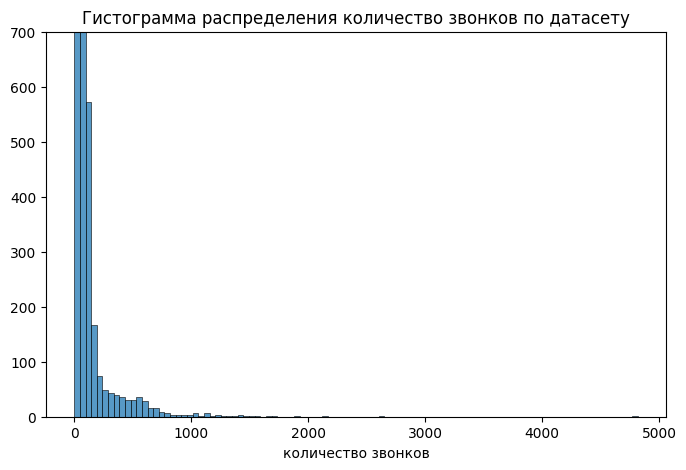

In [12]:
sns.histplot(telecom_dataset, x='calls_count', bins=100).set(xlabel='количество звонков', ylabel='', ylim=(0,700))
plt.title('Гистограмма распределения количество звонков по датасету')
plt.show()

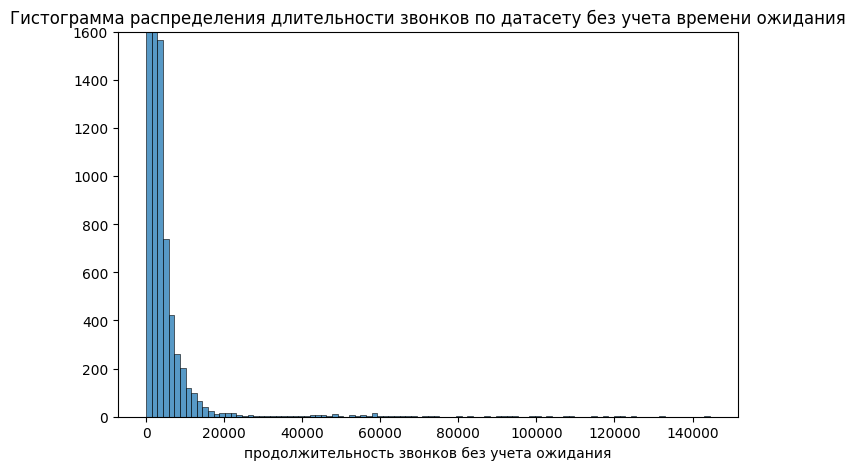

In [13]:
sns.histplot(telecom_dataset, x='call_duration', bins=100).set(xlabel='продолжительность звонков без учета ожидания', ylabel='', ylim=(0,1600))
plt.title('Гистограмма распределения длительности звонков по датасету без учета времени ожидания')
plt.show()

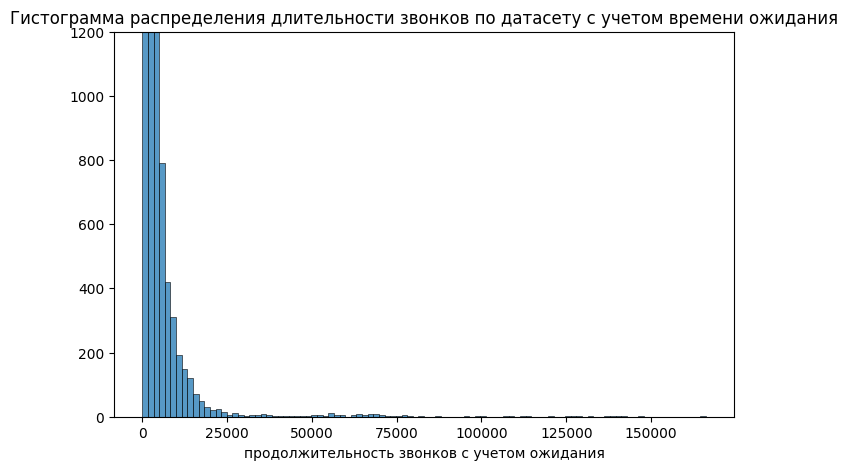

In [14]:
sns.histplot(telecom_dataset, x='total_call_duration', bins=100).set(xlabel='продолжительность звонков с учетом ожидания', ylabel='', ylim=(0,1200))
plt.title('Гистограмма распределения длительности звонков по датасету с учетом времени ожидания')
plt.show()

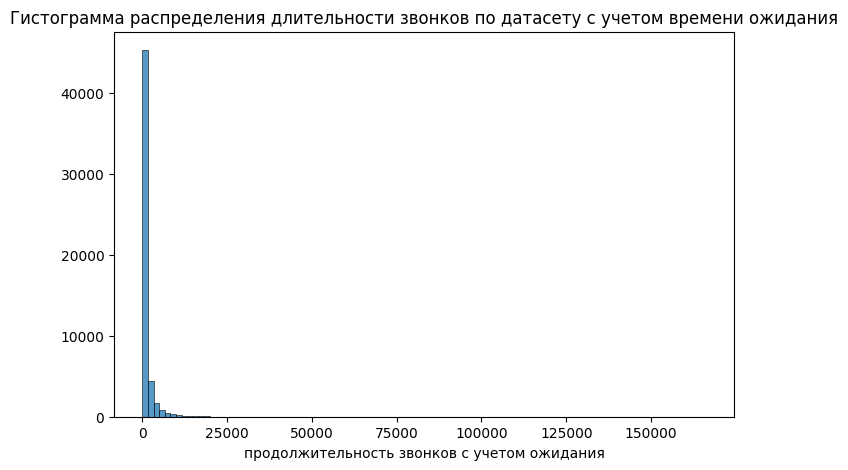

In [15]:
sns.histplot(telecom_dataset, x='total_call_duration', bins=100).set(xlabel='продолжительность звонков с учетом ожидания', ylabel='')
plt.title('Гистограмма распределения длительности звонков по датасету с учетом времени ожидания')
plt.show()

Итак, гистограммы отчетливо показывают что мы имеем сильное жирнохвостовое распределение во всех трех столбцах, воспользуемся ниже метом quatile для определения коллосально выбивающихся значений, после этого определим их характер и примем решение об удалении, или сохранении.

In [16]:
print(f'В таблице датасета telecom_dataset в столбце count методом quantile определим границы по перцентилям')
print(f'99% значений меньше, чем: {telecom_dataset["calls_count"].quantile(0.99)}')
print(f'при этом максимальное значение в данном столбце: {telecom_dataset["calls_count"].max()}')
print('---' * 10)
print(f'произведем тоже самое для столбцов call_duration и total_call_duration')
print(f'в столбце call_duration 99% значений, меньше чем: {telecom_dataset["call_duration"].quantile(0.99)}')
print(f'при этом максимальное значение в данном столбце: {telecom_dataset["call_duration"].max()}')
print('---' * 10)
print(f'в столбце total_call_duration 99% значений, меньше чем: {telecom_dataset["total_call_duration"].quantile(0.99)}')
print(f'при этом максимальное значение в данном столбце: {telecom_dataset["total_call_duration"].max()}')

В таблице датасета telecom_dataset в столбце count методом quantile определим границы по перцентилям
99% значений меньше, чем: 166.15999999999622
при этом максимальное значение в данном столбце: 4817
------------------------------
произведем тоже самое для столбцов call_duration и total_call_duration
в столбце call_duration 99% значений, меньше чем: 10346.319999999992
при этом максимальное значение в данном столбце: 144395
------------------------------
в столбце total_call_duration 99% значений, меньше чем: 12958.07999999995
при этом максимальное значение в данном столбце: 166155


Таким образом, мы можем отсечь по 1% измерений в каждом столбце, и получить гораздо более чистые данные, без аномалий. Которые без сомнения, могут не иметь характер ошибки, но могут перетянуть на себя данные нашего исследования. 
В связи с этим, проверим итоговое количество данных, которое мы потеряем при таком отсечении и примем финальное решение:

In [17]:
tel_dat_new = telecom_dataset.copy()
calls_count_q99 = tel_dat_new["calls_count"].quantile(0.99)
call_duration_q99 = tel_dat_new["call_duration"].quantile(0.99)
total_call_duration_q99 = tel_dat_new["total_call_duration"].quantile(0.99)

tel_dat_new = tel_dat_new.query('calls_count <= @calls_count_q99 and call_duration <= @call_duration_q99 and total_call_duration <= @total_call_duration_q99')
print(f'Количество строк до внесения изменений: {len(telecom_dataset)}')
print(f'Количество строк после внесения изменений: {len(tel_dat_new)}')
print(f'Доля данных которая была утеряна после отсечения равна: {round(100 - len(tel_dat_new)/len(telecom_dataset) * 100, 2)} %')

Количество строк до внесения изменений: 53785
Количество строк после внесения изменений: 52928
Доля данных которая была утеряна после отсечения равна: 1.59 %


После проведенных выше манипуляций вернемся к дубликатам в нашем датасете telecom_dataset и изучим их подробнее

In [18]:
print('Количество полных дубликатов в таблице')
print(tel_dat_new.duplicated().sum())
tel_dat_new[tel_dat_new.duplicated(keep=False)].head()

Количество полных дубликатов в таблице
4811


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
27,166377,2019-08-12 00:00:00+03:00,in,False,0.0,True,2,0,34
28,166377,2019-08-12 00:00:00+03:00,in,False,0.0,True,2,0,34
38,166377,2019-08-14 00:00:00+03:00,in,False,0.0,True,1,0,3


4811 дубликатов в нашем датасете, которые после изучения не показывают никакой закономерности для признания их "неошибочными" вынуждают нас выполнить удаление всех полных дубликатов.

In [19]:
print(len(tel_dat_new))

52928


In [20]:
print(f'Количество полных дубликатов в таблице {tel_dat_new.duplicated().sum()}')
print(f'Количетсво данных до удаления {len(tel_dat_new)}')
telecom_dataset_new = tel_dat_new.drop_duplicates()
print(f'Количество данных после удаления: {len(telecom_dataset_new)}')
print(f'Доля утерянных данных: {round(100 - (len(telecom_dataset_new) / len(tel_dat_new)) * 100, 2)} %')

Количество полных дубликатов в таблице 4811
Количетсво данных до удаления 52928
Количество данных после удаления: 48117
Доля утерянных данных: 9.09 %


#### Промежуточный вывод:
Таким образом, в процессе предобработки:

- Загрузили и изучили данные, а именно:
	- Изменили типы данных в стоблце date_start в сете telecom_clietns
	- убедились в отсутствии пропусков и дубликатов в этой таблице
	- проерили начало и конец периода регистрации для изучения (2019-08-01 и 2019-10-31 соответственно)
	- обнаружили и удалили пропуски в стобце internal в датасете telecom_dataset так они не повлияют на ход исследования. 
	- обнаружили пропуски в столбце operator_id и выдвинули предположение о недошедших внешних входящих звонках, таким пропускам мы присвоили значение заглушку «0» для дальнейшего отслеживаниея, потому как удалять такое количество данных (15.2%) нельзя
	- изменили тип данных в столбце date
	- определели период сбора статистики (2019-08-02 и 2019-11-28)
	- провели анализ столбцов calls_count/call_duration/total_call_duration и удалили аномально большие значения потерям 1.59% данных
    - проверили и избавились от полных дубликатов в датасете не увидев в них нормальной закономерности потеряв 9% данных

### Исследовательский анализ данных EDA:
- Проанализируем общее количество клиентов;
- Посчитаем для каждого пользователя количество сделанных звонков и количество потраченных минут в разрезе месяца и за весь изучаемый период;
- Проверим наличие "выбивающихся" из общего потока пользователей и выдвинем предположение о причине появления таких пользователей.
- Рассчитаем общую выручку в разрезе месяца и за весь изучаемый период
- Рассчитаем LTV (life time value) каждого пользователя для нашего клиента - а именно, сколько денег принес каждый клиент в разрезе месяца/всего изучаемого периода
- Рассмотрим параметры выбора активных клиентов;
- Рассмотрим наличие клиентов ушедших в отток, ответим на вопрос: "Можно ли выделить характерные черты таких клиентов?"
- Проведем поиск клиентов с неоптимальными тарифами (тех, кто мог бы платить меньше)
- Изучим возможные потери в выручке при переводе клиентов находящися на неоптимальных тарифах при переводе их на оптимальные.
- Выдвинем предположение: "как уменьшить риск падения выручки, если все клиенты перейдут на более выгодные тарифы?" и оценим возможные сроки возврата на предыдущие значения по выручкам.

#### Общее количество клиентов
Выведем общее количество клиентов нашего заказчика:

In [21]:
print(f'Общее количество клиентов нашего заказчика: {telecom_dataset_new["user_id"].nunique()}')

Общее количество клиентов нашего заказчика: 307


#### Расчеты для каждого пользователя в разрезе месяца и за весь период
Соберем сводную таблицу из нашего датасета где расчитаем количество звонком и общее время звонков с учетом и без учета времени ожидания в разрезе месяца

In [22]:
telecom_dataset_new['month'] = telecom_dataset_new['date'].dt.month # получим столбец с месяцем для агрегирования
client_pivot_month = telecom_dataset_new.pivot_table(index=['user_id', 'month'], values=['calls_count', 'call_duration', 'total_call_duration'], aggfunc='sum').reset_index()
display(client_pivot_month.head())
client_pivot_total = telecom_dataset_new.pivot_table(index='user_id', values=['calls_count', 'call_duration', 'total_call_duration'], aggfunc='sum').reset_index()
client_pivot_total.head()

,user_id,month,call_duration,calls_count,total_call_duration
0,166377,8,66274,977,79999
1,166377,9,87074,1452,107813
2,166377,10,83758,1406,101952
3,166377,11,80881,1314,98457
4,166391,8,243,18,806


,user_id,call_duration,calls_count,total_call_duration
0,166377,317987,5149,388221
1,166391,260,27,929
2,166392,16652,209,20382
3,166399,244,24,789
4,166405,1128715,14938,1407933


Просто по выводу данных таблиц сложно что-либо сказать, поэтому для начала посчитаем сколько операторов было у каждого пользователя (__для проверки аномальности данных__) в разрезе месяца и общее для всего периода, после этого будем присоединять таблицу с операторами к нашим сводным для расчета выручек. 

#### Расчет общей выручки (месяц/весь период)

В этом разделе удалим все данные которые будут мешать при расчете выручки и присоединим все необходимые таблицы и соберем общие таблицы с которыми и будем работать в дальнейшем

Мы знаем, что:
- Заказчик округляет минуты до полных
- Данные считаются в секундах (приводим доказательство ниже)
- Тарифицирюутся только исходящие звонки
- Звонки Тарифицирюутся с учетом времени ожидания
- Помимо ежемесячной абонетской платы клиенты заказчика платят за каждого опрератора по 100 рублей
- Ежемесячная плата за тариф:

- Тариф А — 5000 ₽,
- B — 2000 ₽,
- С — 1000 ₽.

**Входящие звонки** — бесплатны на всех тарифах,

**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.4 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7 ₽/мин.


Итак, соберем необходимую таблицу для подсчета выручки, однако нам необходимо перед рассчетами определиться в каких единицах измерения предстают перед нами столбцы call_duration и total_call_duration. Для более объективной оценки выполним аггрегирование общей таблицы по ДНЯМ и посмотрим сколько часов/минут/секунд выговаривает в день один operator_id. Напомним что, один id оператора присваевается конкретной станции, данных о сменах операторов и длительности их рабочего дня у нас нет. Поэтому для нас достаточно будет проверить банальную логику.
При этом мы понимаем, что на одну станцию не могут совершаться одновременно звонки и исходящие и входящие, поэтому для нас будет достаточно посчитать общее количество условной единицы времени звонков за день и сравнить с длительностью дня. Однако, мы понимаем что время ожидания может считаться при занятой линии. поэтому для простоты будем работать только со столбцов call_duration

##### Проверка аномалий и определение правил тариффикации данных:

In [23]:
telecom_dataset_new['day'] = telecom_dataset_new['date'].dt.day
day_operator = telecom_dataset_new.pivot_table(index=['operator_id', 'day'], values=['call_duration', 'total_call_duration'], aggfunc='sum').reset_index()
day_operator = day_operator.query('operator_id != 0')
day_operator.head()

,operator_id,day,call_duration,total_call_duration
31,879896.0,1,699,732
32,879896.0,2,575,868
33,879896.0,3,384,707
34,879896.0,4,916,1142
35,879896.0,5,1919,2203


In [24]:
# теперь добавим переменные с которыми будем сравнивать
day_duration_hr = 24
day_duration_min = day_duration_hr*60
day_duration_sec = day_duration_min*60
print(f'Продолжительность дня в часах {day_duration_hr}')
print(f'Продолжительность дня в минутах {day_duration_min}')
print(f'Продолжительность дня в секундах {day_duration_sec}')

Продолжительность дня в часах 24
Продолжительность дня в минутах 1440
Продолжительность дня в секундах 86400


In [25]:
print(f'Общее количество операторов учавствующих в исследовании: {day_operator["operator_id"].nunique()}')
print(f'Количество данных по принципу: оператор/день: {len(day_operator)}')
print(f'Количество раз, когда оператор провел на линии, больше чем часов в дне: {len(day_operator.query("call_duration >= @day_duration_hr"))}')
print(f'Количество раз, когда оператор провел на линии, больше чем минут в дне: {len(day_operator.query("call_duration >= @day_duration_min"))}')
print(f'Количество раз, когда оператор провел на линии, больше чем секунд в дне: {len(day_operator.query("call_duration >= @day_duration_sec"))}')
print(f'Потеряем данных если будем считать данные в часах: {round((len(day_operator.query("call_duration >= @day_duration_hr")) / len(day_operator) * 100), 2)} %')
print(f'Потеряем данных если будем считать данные в минутах: {round((len(day_operator.query("call_duration >= @day_duration_min")) / len(day_operator) * 100), 2)} %')
print(f'Потеряем данных если будем считать данные в секундах: {round((len(day_operator.query("call_duration >= @day_duration_sec")) / len(day_operator) * 100), 2)} %')

Общее количество операторов учавствующих в исследовании: 1092
Количество данных по принципу: оператор/день: 14430
Количество раз, когда оператор провел на линии, больше чем часов в дне: 12990
Количество раз, когда оператор провел на линии, больше чем минут в дне: 5646
Количество раз, когда оператор провел на линии, больше чем секунд в дне: 0
Потеряем данных если будем считать данные в часах: 90.02 %
Потеряем данных если будем считать данные в минутах: 39.13 %
Потеряем данных если будем считать данные в секундах: 0.0 %


Соответственно, на основе анализа выше, мы понимаем что данные в столбце call_duration у нас рассчитанны посекундно __на первый взгляд__, чего и логично придерживаться дальше по ходу исследования. Соответственно, принимаем измерения в секундах и для столбца total_call_duration. Однако, в таком случае мы получаем очень странные значения о времени работы оператора в день, посмотрим на это ниже:

In [26]:
day_operator['minutes_total_call_duration'] = day_operator['total_call_duration'] / 60
print(f'До преобразования значений оператор в среднем в день разговаривает: {round(day_operator["call_duration"].mean())} минуты')
print(f'До преобразования значений оператор в среднем в день работает: {round(day_operator["total_call_duration"].mean())} минуты')
print(f'После преобразования значений оператор в среднем в день работает: {round(day_operator["minutes_total_call_duration"].mean())} минуты')

До преобразования значений оператор в среднем в день разговаривает: 2023 минуты
До преобразования значений оператор в среднем в день работает: 2625 минуты
После преобразования значений оператор в среднем в день работает: 44 минуты


Исходя из вышепоказанного, мы понимаем что наши данные выглядят странно при обоих вариантах. Поэтому, мы отдельно проговорим рекомендацию для заказчика:

__передать данные в тех. отдел для отладки того, что данные в минутах превышают длительность дня.__


 Однако, на данном этапе выдвинем предположение о том, что под одним operator_id может находится несколько станций, или же возможно переключаясь от одного разговора к другому, у нас учитывается удержание во время разговора, как разговор. И будем дальше считать наш датасет так, что __столбцы call_duration и total_call_duration были в минутах__, иначе дальнейшее исследование перестает иметь смысл.  
Перейдем к сбору нашей таблицы для расчета выручек ниже:

In [27]:
tel_data_finance = telecom_dataset_new.copy()
tel_data_finance = tel_data_finance.query('direction == "out"')
tel_data_finance = tel_data_finance.drop(['direction', 'date', 'call_duration', 'is_missed_call'], axis =1)
tel_data_finance_month = tel_data_finance.pivot_table(index=['user_id', 'month', 'internal'], values=['total_call_duration', 'calls_count'], aggfunc='sum').reset_index()
tel_data_finance_month.head()

,user_id,month,internal,calls_count,total_call_duration
0,166377,8,False,912,78029
1,166377,8,True,19,96
2,166377,9,False,1393,105835
3,166377,9,True,13,9
4,166377,10,False,1347,99207


Таким образом, мы собрали таблицу в которой мы видим количество МИНУТ потраченных каждым пользователем в месяц, по внутренним и внешним звонкам, однако необходимо проверить, возможно никто не выходит за установленный лимит, свыше 2000 минут в месяц, и мы сможем избавиться от этих строк и избавить себя от лишней обработки данных.

In [28]:
# проверим есть ли исходящие внутри сети в месяц которые превышают 2000 минут
if len(tel_data_finance_month.query('internal == True & total_call_duration >= 2000')) == 0:
    print('Никто не превышает 2000-минутный лимит по исходящим звонкам внутри сети, можно удалять')
else:
    print('Есть те, кто превышает лимит 2000 минут по исходящим звонкам внутри сети, удалять нельзя, проверь данные')

Есть те, кто превышает лимит 2000 минут по исходящим звонкам внутри сети, удалять нельзя, проверь данные


Так как есть те, кто превышает данный лимит, мы не можем удалить такие данные. В следствии чего оставляем такие данные и будем использовать их далее. 
А после выполним присоединения данных о тарифах и количестве операторов

In [29]:
tel_data_finance_month.merge(telecom_clients, how='left', on='user_id')
tel_data_finance_month.head()

,user_id,month,internal,calls_count,total_call_duration
0,166377,8,False,912,78029
1,166377,8,True,19,96
2,166377,9,False,1393,105835
3,166377,9,True,13,9
4,166377,10,False,1347,99207


In [30]:
operator_month = tel_data_finance.pivot_table(index=['user_id', 'month'], values='operator_id', aggfunc='nunique').reset_index()
operator_month.head()

,user_id,month,operator_id
0,166377,8,5
1,166377,9,4
2,166377,10,5
3,166377,11,5
4,166391,8,1


In [31]:
tel_data_finance_month = tel_data_finance_month.merge(operator_month, how='left', on=['user_id', 'month'])
tel_data_finance_month.head()

,user_id,month,internal,calls_count,total_call_duration,operator_id
0,166377,8,False,912,78029,5
1,166377,8,True,19,96,5
2,166377,9,False,1393,105835,4
3,166377,9,True,13,9,4
4,166377,10,False,1347,99207,5


In [32]:
tel_data_finance_month_merged = tel_data_finance_month.merge(telecom_clients, how='left', on='user_id')
tel_data_finance_month_merged = tel_data_finance_month_merged.drop('date_start', axis=1)
tel_data_finance_month_merged.head()

,user_id,month,internal,calls_count,total_call_duration,operator_id,tariff_plan
0,166377,8,False,912,78029,5,B
1,166377,8,True,19,96,5,B
2,166377,9,False,1393,105835,4,B
3,166377,9,True,13,9,4,B
4,166377,10,False,1347,99207,5,B


In [33]:
costs = pd.DataFrame({'tariff_plan': ['A', 'B', 'C'], 
                     'basic_cost': [5000, 2000, 1000], 
                     'internal_over_limit': [0.1, 0.15, 0.3], 
                     'non_internal': [0.4, 0.5, 0.7], 
                     'operator_cost': [100, 100, 100]})
costs

,tariff_plan,basic_cost,internal_over_limit,non_internal,operator_cost
0,A,5000,0.10,0.4,100
1,B,2000,0.15,0.5,100
2,C,1000,0.30,0.7,100


In [34]:
month_data_merged = tel_data_finance_month_merged.merge(costs, how='left', on='tariff_plan')
month_data_merged.head()

,user_id,month,internal,calls_count,total_call_duration,operator_id,tariff_plan,basic_cost,internal_over_limit,non_internal,operator_cost
0,166377,8,False,912,78029,5,B,2000,0.15,0.5,100
1,166377,8,True,19,96,5,B,2000,0.15,0.5,100
2,166377,9,False,1393,105835,4,B,2000,0.15,0.5,100
3,166377,9,True,13,9,4,B,2000,0.15,0.5,100
4,166377,10,False,1347,99207,5,B,2000,0.15,0.5,100


In [35]:
# произведем расчет выручки

# посчитаем плату за звонки
    # исходящие внешние
non_internal = month_data_merged['internal']==False
month_data_merged.loc[non_internal, 'minutes_paid'] = (
    month_data_merged['total_call_duration'] * month_data_merged['non_internal']
)

    # удалим пропуски
month_data_merged['minutes_paid'] = month_data_merged['minutes_paid'].fillna(0)

    # внутренние
internal_over_limit = ((month_data_merged['internal']==True) & 
                              (month_data_merged['total_call_duration']>2000)
)
month_data_merged.loc[internal_over_limit, 'internal_paid'] = (
    (month_data_merged['total_call_duration'] - 2000) * month_data_merged['internal_over_limit']
)

    # удалим пропуски
month_data_merged['internal_paid'] = month_data_merged['internal_paid'].fillna(0)

# общая сумма за потраченные минуты
month_data_merged['paid_for_minutes_total'] = month_data_merged['minutes_paid'] + \
                                                      month_data_merged['internal_paid']
# операторы
# так как одни и те же операторы совершают и внешние и внутренние вызовы, расчитаем оплату по операторам 
# работающих с внешними вызовами
month_data_merged['operator_paid'] = month_data_merged['operator_cost'] * \
                                             month_data_merged['operator_id']
month_data_merged.loc[(month_data_merged.internal == True), 'operator_paid'] = 0


# общие затраты (выручка от) пользователя за месяц
month_data_merged['month_revenue'] = month_data_merged['paid_for_minutes_total'] + month_data_merged['operator_paid']
month_data_user = month_data_merged.pivot_table(index=['user_id', 'month'], values='month_revenue', aggfunc='sum').reset_index()
month_data_user.head()

,user_id,month,month_revenue
0,166377,8,39514.5
1,166377,9,53317.5
2,166377,10,50103.5
3,166377,11,48192.0
4,166391,8,0.0


таблица с помесячной выручкой для нашего клиента за исследуемый период


,month,month_revenue
0,8,556343.00
1,9,2860128.40
2,10,5164250.25
3,11,5886853.65


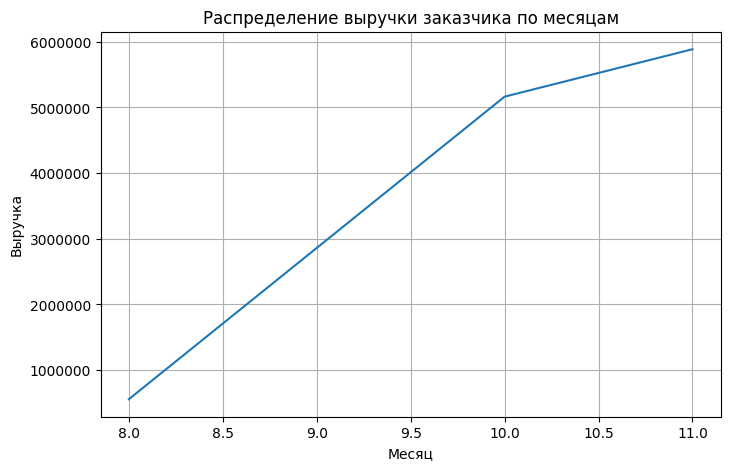

общая выручка нашего клиента за исследуемый период составила: 14467490


,user_id,total_revenue
0,166377,191127
1,166391,0
2,166405,467101
3,166406,208010
4,166407,13247


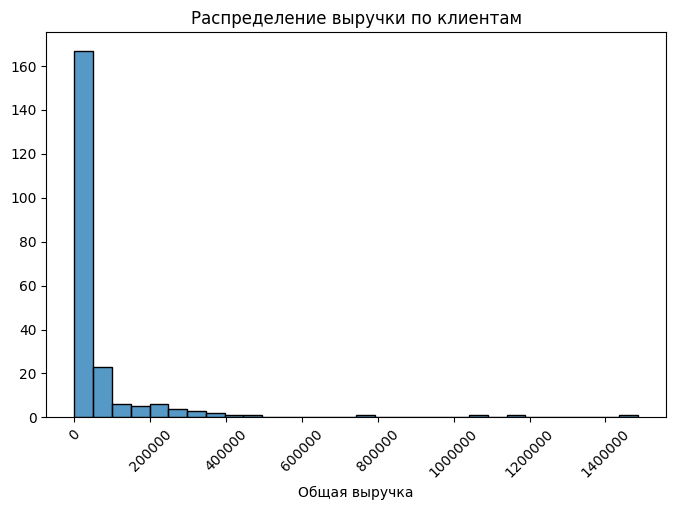

In [36]:
# сразу выполним подсчет общей выручки от пользователя за весь период
total_data_merged = month_data_merged.pivot_table(index='user_id', values='month_revenue', aggfunc='sum').reset_index()
total_data_merged['month_revenue'] = total_data_merged['month_revenue'].astype(int)
total_data_merged.rename(columns={'month_revenue': 'total_revenue'}, inplace=True)
print(f'таблица с помесячной выручкой для нашего клиента за исследуемый период')
mdm = month_data_merged.pivot_table(index='month', values='month_revenue', aggfunc='sum').reset_index()
display(mdm)
sns.lineplot(data=mdm, x='month',y='month_revenue').set(title='Распределение выручки заказчика по месяцам',xlabel='Месяц', ylabel='Выручка')
plt.grid()
plt.ticklabel_format(style='plain')
plt.show()
print(f'общая выручка нашего клиента за исследуемый период составила: {total_data_merged["total_revenue"].sum()}')
display(total_data_merged.head())
sns.histplot(data=total_data_merged,x='total_revenue', bins=30).set(title='Распределение выручки по клиентам', xlabel='Общая выручка', ylabel='')
plt.ticklabel_format(style='plain')
plt.xticks(rotation = 45)
plt.show()

Таким образом, мы выполнили расчет общей выручки нашего клиента за изучаемый период. 
__Выручка за весь период составила 14467490 условных денежных единиц__
Не смотря на то, что данные за август неполные, мы не знаем когда наша компания начала работу и мы предполагаем что в августе компания только раскачивалсь, поэтому данные оставим, также как и данные за ноябрь не являются полными, однако датой анализа берем дату сразу после последней известной даты получения статистики и считаем её как __сегодняшний день__ и подсчеты соответсвенно выполняем на сегодняшний день. 

Также, по графикам мы видим что выручка растет от месяца к месяцу, а также по графику распределения выручки по клиентам мы можем сделать вполне очевидный вывод, что клиенты приносят нам разное количество денежных средств и есть клиенты которые принесли нам выбивающеся много денежных средств за весь период.

#### Выполним поиск активных клиентов

Несмотря на то что в наших данных пристуствуют данные за следующие месяцы: Август, сентрябрь, октябрь, ноябрь (неполный), мы будем брать данные за все месяцы, но пометим что данные за ноябрь неполные и будут требовать пересчета после добавления данных. 

Активными клиентами будем считать тех, кто пользовался нашим сервисом в ноябре. 

In [37]:
active_clients = month_data_merged[month_data_merged['month'] == 11]['user_id'].unique()
print(f'общее количество активных пользователей: {len(active_clients)}')

общее количество активных пользователей: 179


In [38]:
# теперь соберем датасет с активными клиентами по которым и будем расчитывать интересующие нас значения
active_month_data = month_data_merged.query('user_id in @active_clients')
# общие затраты (выручка от) активного пользователя за месяц
month_data_active = active_month_data.pivot_table(index=['user_id', 'month'], values='month_revenue', aggfunc='sum').reset_index()
month_data_active.head()

,user_id,month,month_revenue
0,166377,8,39514.5
1,166377,9,53317.5
2,166377,10,50103.5
3,166377,11,48192.0
4,166405,8,25483.5


In [39]:
# присоединим к нашему датасету данные о тарифах и их стоимости

month_data_active_tariff = month_data_active.merge(telecom_clients, on='user_id')
month_data_active_tariff_costs = month_data_active_tariff.merge(costs, on='tariff_plan')
month_data_active_tariff_costs = month_data_active_tariff_costs.drop(['date_start', 'internal_over_limit', 'non_internal', 'operator_cost'], axis=1)
month_data_active_tariff_costs['overpay'] = month_data_active_tariff_costs['month_revenue'] - month_data_active_tariff_costs['basic_cost']
month_data_active_tariff_costs.loc[(month_data_active_tariff_costs.overpay < 0), 'overpay'] = 0
display(month_data_active_tariff_costs.head())
overpay_by_user = month_data_active_tariff_costs.query("overpay != 0").pivot_table(index='user_id',values='overpay',aggfunc='sum')
print(f'количество пользователей которые переплачивают по своим тарифам: {len(overpay_by_user)}')

,user_id,month,month_revenue,tariff_plan,basic_cost,overpay
0,166377,8,39514.5,B,2000,37514.5
1,166377,9,53317.5,B,2000,51317.5
2,166377,10,50103.5,B,2000,48103.5
3,166377,11,48192.0,B,2000,46192.0
4,166405,8,25483.5,B,2000,23483.5


количество пользователей которые переплачивают по своим тарифам: 130


Достаточно много активных пользователей переплачивают на текущих тарифах, ниже рассчитаем предложение по переходу на более выгодные тарифы для них

In [40]:
# суммируем датасет по пользователям и месяцам
mean_minutes_by_user = active_month_data.groupby(['user_id', 'month', 'internal'])\
    .agg({'total_call_duration':'sum'}).groupby(['user_id','internal'])\
    .agg({'total_call_duration':'mean'}).reset_index()

mean_minutes_by_user = mean_minutes_by_user.query('internal == False | (internal == True & total_call_duration>2000)')\
    .reset_index(drop=True)

# присоединим информацию о стоимости
mean_minutes_by_user = mean_minutes_by_user.merge(telecom_clients[['user_id', 'tariff_plan']], 
                                                          how='left', 
                                                          on='user_id')\
                                           .merge(costs[['tariff_plan', 'basic_cost', 
                                                         'internal_over_limit','non_internal']],
                                                  how='left',
                                                  on='tariff_plan')

mean_minutes_by_user['total_paid'] = (
    mean_minutes_by_user[mean_minutes_by_user['internal']==False]['total_call_duration'] *
    mean_minutes_by_user['non_internal'] +
    mean_minutes_by_user['basic_cost']
).fillna((mean_minutes_by_user[mean_minutes_by_user['internal']==True]['total_call_duration'] - 2000) *
                        mean_minutes_by_user['internal_over_limit']
        )

In [41]:
# проверка затрат и предложение нового тарифа
def check_tariff(data):
    j=0
    for tariff in costs['tariff_plan']:
        
        for i in range(len(data)):
            if tariff != data.loc[i,'tariff_plan'] and data.loc[i,'internal']==False:
                data.loc[i, 'prop_'+tariff] = (
                    costs.loc[j,'basic_cost'] + 
                    costs.loc[j,'non_internal'] * 
                    data.loc[i, 'total_call_duration']
                )
                
            elif tariff != data.loc[i,'tariff_plan'] and data.loc[i,'internal']==True:
                data.loc[i, 'prop_'+tariff] = (
                    (data.loc[i, 'total_call_duration'] - 2000) *
                        costs.loc[j, 'internal_over_limit']
                )
                
            else:
                data.loc[i, 'prop_'+tariff] = np.nan
                   
            if pd.isna(mean_minutes_by_user.loc[i, 'prop_'+tariff]) != True:      
                if data.loc[i, 'prop_'+tariff] < data.loc[i, 'total_paid']:
                    data.loc[i, 'final_proposal_tariff'] = tariff
                else:
                    data.loc[i, 'final_proposal_tariff'] = data.loc[i, 'tariff_plan']

        j+=1
    
    return data.groupby('user_id').agg({'tariff_plan':'first',
                                        'total_paid':'sum',
                                        'prop_A':'sum',
                                        'prop_B':'sum',
                                        'prop_C':'sum',
                                        'final_proposal_tariff':'first'})

In [42]:
# предлагаем тарифы
propose_tariff = check_tariff(mean_minutes_by_user).reset_index()
# оставляем только тех пользователей, кому необходимо сменить тариф, для того чтобы платить меньше
propose_tariff_result = propose_tariff.query('tariff_plan != final_proposal_tariff').reset_index()
print(f'{len(propose_tariff_result)} - количество пользователей которым необходимо сменить тариф')
propose_tariff_result.head()

85 - количество пользователей которым необходимо сменить тариф


,index,user_id,tariff_plan,total_paid,prop_A,prop_B,prop_C,final_proposal_tariff
0,3,166407,A,7637.250,0.0,5384.275,6053.75,C
1,5,166487,C,5775.400,7728.8,5411.000,0.00,B
2,8,166511,C,93972.425,58127.1,68408.875,0.00,B
3,9,166520,C,62941.425,40395.1,46243.875,0.00,B
4,11,166541,A,6969.200,0.0,4461.500,4446.10,C


По результатам анализа мы получили 85 пользователей которым необходимо сменить тариф. Теперь нам необходимо будет оценить потери в выручке и предположительный срок выхода на прежние показатели. 

Перед этим дадим визуализацию получившимся данным, ниже соберем таблицу количества пользователей на тариффах до и после оптимизации

In [43]:
compare_tariff = propose_tariff.pivot_table(index='tariff_plan', values='user_id', aggfunc='count').reset_index()
compare_cnt_tariff = compare_tariff.merge(propose_tariff.pivot_table(index='final_proposal_tariff', values='user_id', aggfunc='count').reset_index().rename(columns={'final_proposal_tariff': 'tariff_plan'}), on='tariff_plan')
compare_cnt_tariff = compare_cnt_tariff.rename(columns={'user_id_x': 'cnt_old_tariff', 'user_id_y': 'cnt_new_tariff'})

In [44]:
compare_cnt_tariff['percentage'] = abs(round((compare_cnt_tariff['cnt_old_tariff']-compare_cnt_tariff['cnt_new_tariff']) / compare_cnt_tariff['cnt_new_tariff'] * 100))
compare_cnt_tariff

,tariff_plan,cnt_old_tariff,cnt_new_tariff,percentage
0,A,24,15,60.0
1,B,70,88,20.0
2,C,85,76,12.0


Дадим пояснение, в столбце `percentage` находится абсолютное изменения количества пользователей на каждом тарифе

Ниже, соберем кросс-таблицу о том, как распределились рекомендации по смене тарифных планов.

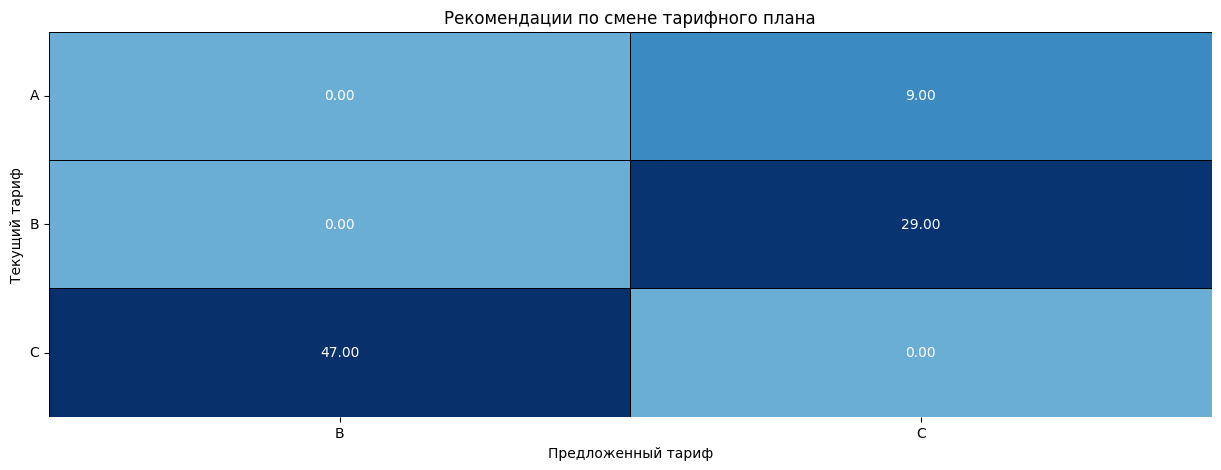

In [45]:
rows = propose_tariff_result['final_proposal_tariff']
cols = propose_tariff_result['tariff_plan']

# построим кросс-таблицу по тарифам

plt.figure(figsize=(15, 5))
sns.heatmap(pd.crosstab(cols, rows, dropna=False), 
                 annot=True, fmt='.2f', 
                 linewidths=.42, linecolor='black',
                 cmap='Blues', cbar=False,
                 vmin=-20, vmax=30, center= 0)
plt.yticks(rotation=0)
plt.title('Рекомендации по смене тарифного плана')
plt.ylabel('Текущий тариф')
plt.xlabel('Предложенный тариф')

plt.show()

Поясним кросс-таблицу из блока выше:

- 9 Клиентам выгоден переход с тарифа А на С
- 29 Клиентам выгоден переход с тарифа В на С
- 47 Клиентам выгоден переход с тарифа С на В

Таким образом большей части клиентов выгоден тариф с переходом на "подорожание" по абонентской плате, и по снижению цены оплаты за минуты.

Ниже построим график того, как распределялись тарифы до и после внесения предложений

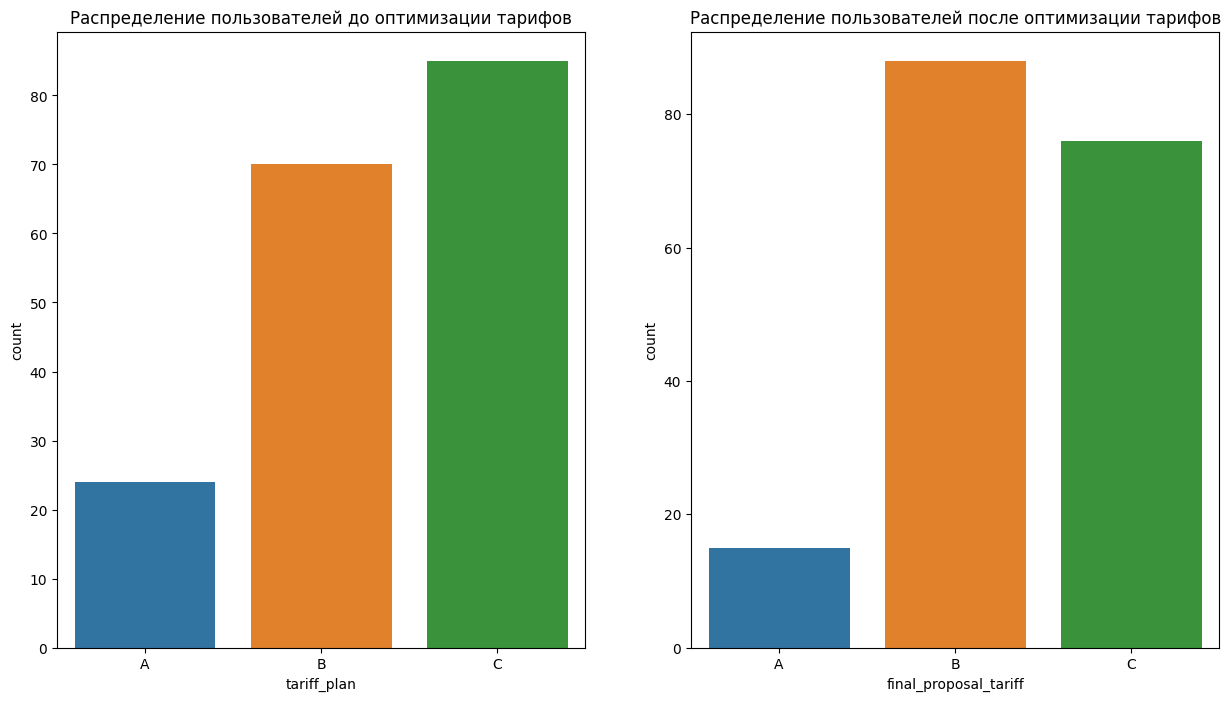

In [46]:
fig, ax =plt.subplots(1,2)
sns.countplot(data=propose_tariff, x='tariff_plan', order='ABC', ax=ax[0]).set(title='Распределение пользователей до оптимизации тарифов')
sns.countplot(data=propose_tariff, x='final_proposal_tariff', order='ABC', ax=ax[1]).set(title='Распределение пользователей после оптимизации тарифов')
fig.set_size_inches(15, 8)
fig.show()

#### Потеря выручки

In [47]:
propose_tariff = propose_tariff.reset_index()
new_tariffs = propose_tariff[['user_id', 'final_proposal_tariff']]
new_tariffs = new_tariffs.rename(columns={'final_proposal_tariff': 'tariff_plan'})
new_tariffs.head()

,user_id,tariff_plan
0,166377,B
1,166405,B
2,166406,B
3,166407,C
4,166485,B


In [48]:
# соберем данные где предложим пользователям, кому необходимо перейти на новый тариф, заменим их, 
# а другим пользователям такие тарифы оставим

# суммируем датасет по пользователям и месяцам
mby = active_month_data.groupby(['user_id', 'month', 'internal'])\
    .agg({'total_call_duration':'sum'}).groupby(['user_id','internal'])\
    .agg({'total_call_duration':'mean'}).reset_index()

mby = mby.query('internal == False | (internal == True & total_call_duration>2000)')\
    .reset_index(drop=True)

# присоединим информацию о стоимости
mby = mby.merge(new_tariffs, on='user_id')
mby = mby.merge(costs, on='tariff_plan')

mby['new_total_paid'] = (
    mby[mby['internal']==False]['total_call_duration'] *
    mby['non_internal'] +
    mby['basic_cost']
).fillna((mby[mby['internal']==True]['total_call_duration'] - 2000) *
                        mby['internal_over_limit']
        )
mby = mby.rename(columns={'tariff_plan': 'new_tariff_plan'})
mby.head()

,user_id,internal,total_call_duration,new_tariff_plan,basic_cost,internal_over_limit,non_internal,operator_cost,new_total_paid
0,166377,False,94613.750000,B,2000,0.15,0.5,100,49306.875
1,166405,False,232350.750000,B,2000,0.15,0.5,100,118175.375
2,166406,False,103555.250000,B,2000,0.15,0.5,100,53777.625
3,166485,False,110219.250000,B,2000,0.15,0.5,100,57109.625
4,166485,True,13544.333333,B,2000,0.15,0.5,100,1731.650


In [49]:
total_paid_old_values = propose_tariff[['user_id', 'tariff_plan', 'total_paid']]
total_paid_new_values = mby[['user_id', 'new_tariff_plan', 'new_total_paid']]
compare_revenue = total_paid_old_values.merge(total_paid_new_values, on='user_id')
compare_revenue.head()

,user_id,tariff_plan,total_paid,new_tariff_plan,new_total_paid
0,166377,B,49306.875,B,49306.875
1,166405,B,118175.375,B,118175.375
2,166406,B,53777.625,B,53777.625
3,166407,A,7637.250,C,5001.200
4,166407,A,7637.250,C,1052.550


In [50]:
compare_revenue['revenue_loss'] = compare_revenue['total_paid'] - compare_revenue['new_total_paid']
compare_revenue.loc[(compare_revenue.revenue_loss < 0), 'revenue_loss'] = 0
print(f'Общая выгода клиентов/потери заказчика: {round(sum(compare_revenue.revenue_loss))}')

Общая выгода клиентов/потери заказчика: 1812148


Как мы видим, при переводе пользователей на более оптимальные тарифы наш заказчик будет терять деньги, однако, целью нашего исследования было предложить такой перевод для сохранения наших текущих клиентов и последующей "сарафанной" рекламы новым пользователям. В качестве компенсирования таких потерь можно рекомендовать использовать данное исследование в маргетинговых целях, то есть привлекать новых клиентов, таким образом мы сможем максимально быстро восполнить потерянные объемы. Для примера произведем приблизительный расчет того, сколько в среднем один пользователь приносит денег в месяц и после этого посчитаем необходимое нам количество новых пользователей для перекрытия убытков. 

In [51]:
# расчет средней выручки от пользователя в месяц
user_mean_revenue = month_data_active.pivot_table(index=['user_id'], values='month_revenue', aggfunc='mean')
print(f'в среднем один пользователь приносит в месяц: {round(user_mean_revenue["month_revenue"].mean())} условной денежной единицы')
print(f'Таким образом нам потребуется в следующий месяц найти {round(sum(compare_revenue.revenue_loss) / user_mean_revenue["month_revenue"].mean())} пользователей для покрытия убытков') 

в среднем один пользователь приносит в месяц: 25197 условной денежной единицы
Таким образом нам потребуется в следующий месяц найти 72 пользователей для покрытия убытков


Таким образом, если мы найдем к следующему месяцу 72 новых пользователя при помощи маркетинга, то мы перекроем наши убытки в первый же месяц. Однако, необходимо понять: "72", это много? Или мало?  Для этого взглянем на то, как изменялось количество пользователей каждый месяц. 

In [52]:
clients_month = telecom_clients.copy()
clients_month['month'] = clients_month['date_start'].dt.month
clients_month = clients_month.pivot_table(index='month', values='user_id', aggfunc='nunique').reset_index()
print(f'Компания в сентябре привлекла на {abs(clients_month["user_id"][1] - clients_month["user_id"][0])} клиентов меньше, чем в августе')
print(f'А в октябре привлекла на {clients_month["user_id"][2] - clients_month["user_id"][1]} клиентов больше , чем в сентябре')
clients_month

Компания в сентябре привлекла на 27 клиентов меньше, чем в августе
А в октябре привлекла на 12 клиентов больше , чем в сентябре


,month,user_id
0,8,258
1,9,231
2,10,243


[Text(0.5, 1.0, 'Динамика привлечения новых пользователей'),
 Text(0.5, 0, 'Месяц'),
 Text(0, 0.5, 'Количество привлеченных пользователей')]

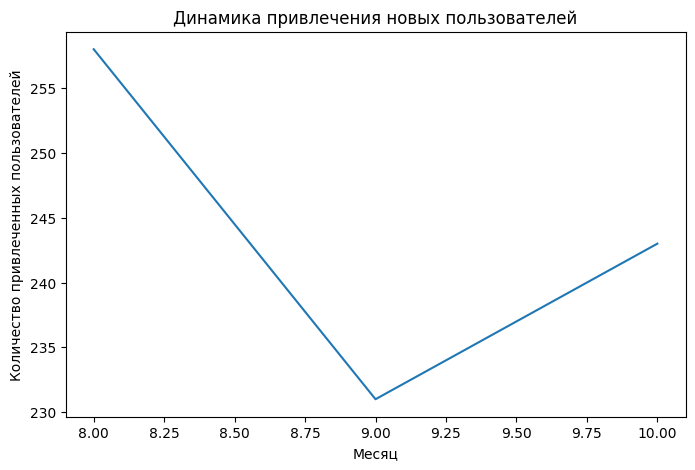

In [53]:
sns.lineplot(data=clients_month, x='month', y='user_id').set(title='Динамика привлечения новых пользователей', xlabel='Месяц', ylabel='Количество привлеченных пользователей')

Таким образом, мы понимаем что компания работает в рост по поиску новых клиентов. Однако мы обладаем не таким большим количеством данных чтоб выдвинуть точные прогнозы. В связи с чем рекомендуем __использовать данное исследование в целях PR-кампании для привлечения новых пользователей__

#### Расчет LTV пользователей по когоротам

Применим __прогностический подход к расчёту LTV__ а именно:
- Сначала выполним расчет LTV через ARPU
- Затем выполним покогортный расчет LTV, так как датой анализа берем дату сразу после последнего дня статистики, выполним подсчет покогортно всех имеющихся у нас пользователей на текущий момент. Таким образом, каждому клиенту в зависимости от месяца регистрации присвоим номер когорты и рассчитаем LTV за весь период в этих когортах.

##### __Рассчитаем LTV через ARPU__
`LTV = ARPU x Lifetime`

`ARPU = Общий доход/Количество клиентов за сопоставимый период времени.`

`Lifetime` — это время, в течение которого пользователь взаимодействует с компанией.

Например, 10 человек принесли компании 12000 рублей прибыли за квартал. Пользователи остаются активными в течении квартала. ARPU = 12000 / 10 = 1200 рублей. LTV = 1200*4 = 4800 рублей — стоимость одного клиента за квартал.

__В нашем случае: Мы имеем общий доход который принесли нам активные пользователи за весь период, количество этих пользователей, и количество месяцев, которые эти пользователи были с нами. Таким образом выполним расчет LTV

In [54]:
arpu = sum(month_data_active['month_revenue'])/month_data_active['user_id'].nunique()
ltv = arpu * month_data_active['month'].nunique()
print(f'LTV одного клиента за {month_data_active["month"].nunique()} месяца составит: {round(ltv,2)}')

LTV одного клиента за 4 месяца составит: 257537.19


##### __Выполним покогортный расчет LTV__
Так как датой анализа берем дату сразу после последнего дня статистики, выполним подсчет покогортно всех имеющихся у нас пользователей на текущий момент, то есть активных. Таким образом, каждому клиенту в зависимости от месяца регистрации присвоим номер когорты и рассчитаем LTV за весь период в этих когортах.

In [55]:
user_start = telecom_clients[['user_id', 'date_start']]
user_start['month_start'] = user_start['date_start'].dt.month
user_start.head()

,user_id,date_start,month_start
0,166713,2019-08-15,8
1,166901,2019-08-23,8
2,168527,2019-10-29,10
3,167097,2019-09-01,9
4,168193,2019-10-16,10


In [56]:
date_cohort = pd.DataFrame({'date_start' : telecom_clients['date_start']})
date_cohort['month_start'] = date_cohort['date_start'].dt.month
print(f'количество месяцев регистраций пользователей, а значит и количество когорт пользователей: {date_cohort["month_start"].nunique()}')
date_cohort = date_cohort.drop('date_start', axis=1)
date_cohort = date_cohort.sort_values(by='month_start')
date_cohort = date_cohort.drop_duplicates().reset_index(drop=True)
date_cohort.index = np.arange(1, len(date_cohort) + 1)
date_cohort = date_cohort.reset_index()
date_cohort = date_cohort.rename(columns={'index': 'cohort'})
date_cohort.head()

количество месяцев регистраций пользователей, а значит и количество когорт пользователей: 3


,cohort,month_start
0,1,8
1,2,9
2,3,10


In [57]:
user_cohort = user_start.merge(date_cohort, on='month_start')
user_cohort.head()

,user_id,date_start,month_start,cohort
0,166713,2019-08-15,8,1
1,166901,2019-08-23,8,1
2,167050,2019-08-29,8,1
3,166610,2019-08-12,8,1
4,166897,2019-08-23,8,1


In [58]:
user_cohort_data = month_data_active.merge(user_cohort, on='user_id')
user_cohort_data.head()

,user_id,month,month_revenue,date_start,month_start,cohort
0,166377,8,39514.5,2019-08-01,8,1
1,166377,9,53317.5,2019-08-01,8,1
2,166377,10,50103.5,2019-08-01,8,1
3,166377,11,48192.0,2019-08-01,8,1
4,166405,8,25483.5,2019-08-02,8,1


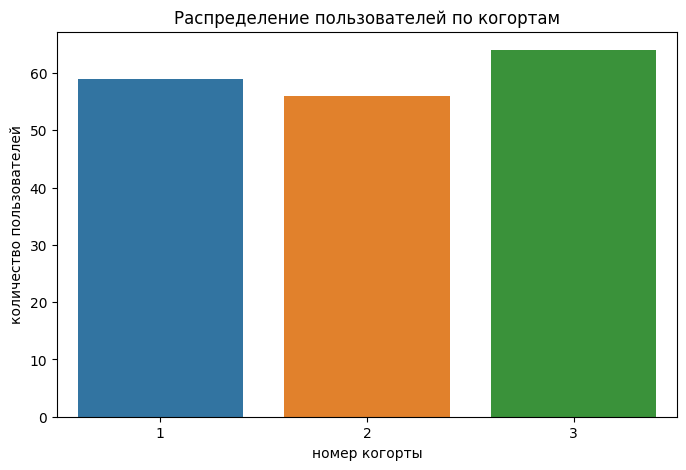

In [59]:
# оценим количество пользователей в каждой когорте
cohort_sizes = user_cohort_data.pivot_table(index='cohort', values='user_id', aggfunc='nunique').reset_index()
cohort_sizes.head()
sns.barplot(data=cohort_sizes, x='cohort', y='user_id').set(title='Распределение пользователей по когортам', xlabel='номер когорты', ylabel='количество пользователей')
plt.show()

In [60]:
cohort_revenue = user_cohort_data.pivot_table(index='cohort', values=['month_revenue'], aggfunc='sum').reset_index()
cohort_revenue_sizes = cohort_revenue.merge(cohort_sizes, on='cohort')

,cohort,cohort_revenue,cohort_size,ltv
0,1,5135481.75,59,87042.06
1,2,2311098.50,56,41269.62
2,3,4078209.15,64,63722.02


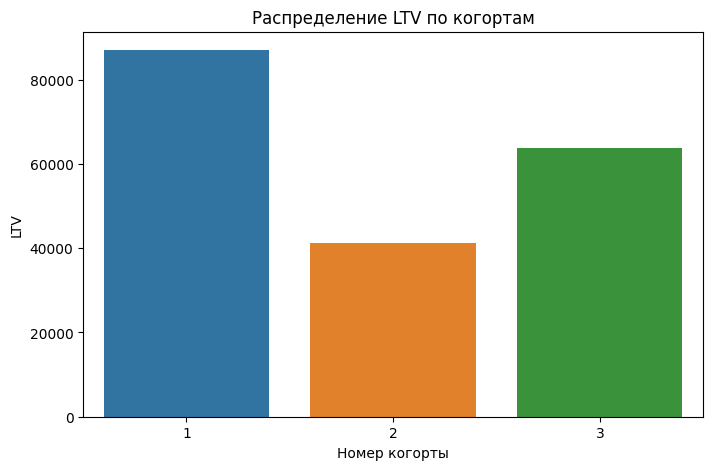

In [61]:
cohort_revenue_sizes = cohort_revenue_sizes.rename(columns={'month_revenue': 'cohort_revenue', 'user_id': 'cohort_size'})
cohort_revenue_sizes['ltv'] = round(cohort_revenue_sizes['cohort_revenue'] / cohort_revenue_sizes['cohort_size'],2)
display(cohort_revenue_sizes.head())
sns.barplot(data=cohort_revenue_sizes, x='cohort', y='ltv').set(title='Распределение LTV по когортам', xlabel='Номер когорты', ylabel='LTV')
plt.show()

#### Промежуточный вывод:

В процессе исследовательского анализа данных, выполнили:
- Проанализировали общее количество клиентов, их получилось - 307
- Посчитали для каждого пользователя количество сделанных звонков и количество потраченных минут в разрезе месяца и за весь изучаемый период;
- Проверили наличие "выбивающихся" из общего потока пользователей и выдвинем предположение о причине появления таких пользователей:
Были обнаружены аномальные значения в столбцах `call_duration`, `total_call_duration`, а именно: в таких столбцах пристуствует большое количество аномалий, если считать их в минутах, полное искажение данных и потеря смысла такого анализа если считать такие столбцы в секундах. В связи с чем, приняли что считать датасет будем в минутах, и оставили рекомендацию передать этот вопрос на рассмотрение в тех. отдел.
- Рассчитали общую выручку в разрезе месяца и за весь изучаемый период, так:
Выручка за каждый месяц изучаемого периода составила:	
8 - 556343
9 - 2860128
10 - 5164250
11 - 5886853
За весь период: 14467490 условных денежных единиц
- Рассмотрели параметры выбора активных клиентов, таких оказалось - 179; Параметром выбора определили тех, кто пользовался нашими услугами в последнем месяце (ноябре) изучаемого периода
- Провели поиск клиентов с неоптимальными тарифами (тех, кто мог бы платить меньше), таких оказалось - 85. 
- Изучили возможные потери в выручке при переводе клиентов находящися на неоптимальных тарифах при переводе их на оптимальные
Потеря составляет - 1812148 условных денежных единиц
- Выдвинули предположение: "как уменьшить риск падения выручки, если все клиенты перейдут на более выгодные тарифы?" и оценим возможные сроки возврата на предыдущие значения по выручкам:
__Самое главное предложение - работать с данными такого исследования в рамках PR-компании после перевода клиентов, так как это может стать отличным маркетинговым ходом, и если по результату успешной маркетинговой компании в следующем месяце мы получим около 72 новых клиентов то мы нивелируем таким образом убытки уже в следующем месяце.__
Также в статистическом исследовании проверили гипотезу о смене абонетской платы на тарифах, и ответили на вопрос, можно ли таким образом минимизировать потери в выручке.

- Рассчитали LTV (life time value) каждого пользователя для нашего клиента - а именно, сколько денег принес каждый клиент в разрезе месяца/всего изучаемого периода и определили как распределяются данные покогортно



### Статистические гипотезы:

Сформулируем и проверим статистические гипотезы по которым можно сделать полезные выводы для бизнеса:
1. Средняя выручка клиента до перевода на оптимальные тарифы отличается от выручки после перевода на оптимальные тарифы.
2. Средняя выручка заказчика изменится при изменении абонентской платы у тарифных планов

#### Выручка до и после перевода на оптимальные тарифы 

- Н0 - нулевая гипотеза: Статистически значимых различий в средней выручке клиента после перевода на оптимальные тарифы нет
- Н1 - альтернативная гипотеза: Статистически значимых различий в средней выручке клиента после перевода на оптимальные тарифы есть

Так как, мы проводим немножественную проверку на одних и тех же данных, не будем применять поправку Бонферрони, и выберем для теста Непараметрический тест Уилкоксона-Манна-Уитни, так как данные мы получили с достаточно большими аномалиями и выбросами.

In [62]:
sample_a = compare_revenue['total_paid'] # старые значения 
sample_b = compare_revenue['new_total_paid'] # новые значения

# зададим пороговое значение альфа и разделим его на количество сравнений 
# которые мы производим на одних и тех же данных
alpha = 0.05

results = st.mannwhitneyu(sample_a, sample_b, alternative='two-sided') # ваш код

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

# рассчитаем метрики для интепретации результатов  
mean_val = round(sample_b.mean()/ (sample_a.mean()) - 1, 3) * 100
abs_val = sample_b.mean() - sample_a.mean()
val = sample_b.sum() - sample_a.sum()
print(f'Относительные изменения после смены тарифа - {mean_val:.4} %')
print(f'Абсолютное среднего чека после смены тарифа - {abs_val:.2f}')
print(f'Изменение выручки после смены тарифа - {val:.2f}')

p-значение:  0.005041671278324794
Отвергаем нулевую гипотезу: разница статистически значима
Относительные изменения после смены тарифа - -28.8 %
Абсолютное среднего чека после смены тарифа - -9293.06
Изменение выручки после смены тарифа - -1812147.56


In [63]:
compare_revenue.head()

,user_id,tariff_plan,total_paid,new_tariff_plan,new_total_paid,revenue_loss
0,166377,B,49306.875,B,49306.875,0.00
1,166405,B,118175.375,B,118175.375,0.00
2,166406,B,53777.625,B,53777.625,0.00
3,166407,A,7637.250,C,5001.200,2636.05
4,166407,A,7637.250,C,1052.550,6584.70


По результатам проверки гипотезы мы видим, что статистически значимые различия имеют место быть, и при смене тарифа на оптимальные мы наблюдаем изменение выручки после смены тарифа, при этом изменение идет в сторону убытков, как и ожидалось.

#### Средняя выручка заказчика при изменении абонентской платы у тарифных планов

- Н0 - нулевая гипотеза: Статистически значимых различий в средней выручке клиента после изменения абонетской платы у тарифных планов нет
- Н1 - альтернативная гипотеза: Статистически значимых различий в средней выручке клиента после изменения абонетской платы у тарифных планов есть

По нашим данным мы увидели то, что самое распространенное предложение по переходу, это с тарифа А на тарифы В и С. Соответственно, мы можем предложить нашему клиенту немного скорректировать тарифные планы, а именно, снизить абонентскую плату у тарифа **А** на 2010 условных денежных единиц, но при этом поднять плату за исходящие не внешние звонки на 0.05, а у тарифного плана **В** снизить такую плату на 10 условных денежных единиц и поднять оплату за исходящие не внешние звонки на 0.05, а у **С** снизить такую абонентскую плату на 10  условных денежных единиц и снизить оплату на 0.05. Таким образом получим следующую тарифную сетку:
Ежемесячная плата за тариф:

- **Тариф А** — 2990 ₽,
- **B** — 1990 ₽,
- **С** — 990 ₽.

**Входящие звонки** — бесплатны на всех тарифах,

**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.45 ₽/мин.,
- B — 0.55 ₽/мин.,
- C — 0.65 ₽/мин.

За каждого оператора клиент платит 100 ₽ в месяц на любом тарифе — дополнительно к стоимости тарифа и цене звонков.
Выполним расчеты по данным клиентов которых еще не перевели на оптимальные тарифы, таким образом сохраним логику что такие действия 

Теперь поясним, почему мы выбираем такие цифры для изменения:

- Тариф А, самый непопулярный тариф у нашего заказчика, и оно понятно почему, визуально, ежемесячная плата почти в два раза больше, а плата за услуги меньше ненамного. Однако для нашего клиента, эта абонентская плата не играет настолько значимой роли в формате конечной выручки. Также, мы сделали закономерный шаг для тарифов - 1000 условных денежных единиц. Все это поможет нам при дальнейшей работе с новыми клиентами. 
- Снизив на "некруглую" сумму, и получив тарифы кончающиеся на "..990" мы визуально изменили тарифную сетку так, что:
    - Отделу маркетинга вкупе с нашей акцией по переводу пользователей на оптимальные тарифы будет дана возможность гораздно эффективнее провести PR-кампанию по привлечению новых клиентов. 
    - В целом, мы продали визуальную выгоду не потеряв для себя в выручке
- Измениние стоимости исходящих звонков, тарифу А и В мы подняли стоимость на 0.05, а тарифу С снизили эту стоимость на 0.05, этим мы добились того, что:
    - Опять же у тарифов не появилось унификации, но при этом пропал странный разброс, откуда собственно и появлялись неоптимальные клиенты.
    - Поднятие для тарифа А и В выглядит абсолютно незначительным и выглядящим как стандартный плановый подъем цены (Например, мне таким образом поднимает оплату мой оператор практически каждые полгода), а тариф С получил снижение цены.
    
В итоге, мы посмотрим как изменится количество пользователей которым необходима смена тарифа и сможем ли мы снизить наши убытки таким образом. 

In [64]:
costs_alt = costs.copy() #создаем новую таблицу с тарифами
costs_alt['basic_cost'][0] -= 2010
costs_alt['basic_cost'][1:3] -= 10
costs_alt['non_internal'][0:2] +=0.05
costs_alt['non_internal'][2] -=0.05
costs_alt

,tariff_plan,basic_cost,internal_over_limit,non_internal,operator_cost
0,A,2990,0.10,0.45,100
1,B,1990,0.15,0.55,100
2,C,990,0.30,0.65,100


In [65]:
# суммируем датасет по пользователям и месяцам
mby_alt = active_month_data.groupby(['user_id', 'month', 'internal'])\
    .agg({'total_call_duration':'sum'}).groupby(['user_id','internal'])\
    .agg({'total_call_duration':'mean'}).reset_index()

mby_alt = mby_alt.query('internal == False | (internal == True & total_call_duration>2000)')\
    .reset_index(drop=True)

# присоединим информацию о стоимости
mby_alt = mby_alt.merge(new_tariffs, on='user_id')
mby_alt = mby_alt.merge(costs_alt, on='tariff_plan')

mby_alt['total_paid'] = (
    mby_alt[mby['internal']==False]['total_call_duration'] *
    mby_alt['non_internal'] +
    mby_alt['basic_cost']
).fillna((mby_alt[mby_alt['internal']==True]['total_call_duration'] - 2000) *
                        mby_alt['internal_over_limit']
        )
mby_alt.head()

,user_id,internal,total_call_duration,tariff_plan,basic_cost,internal_over_limit,non_internal,operator_cost,total_paid
0,166377,False,94613.750000,B,1990,0.15,0.55,100,54027.5625
1,166405,False,232350.750000,B,1990,0.15,0.55,100,129782.9125
2,166406,False,103555.250000,B,1990,0.15,0.55,100,58945.3875
3,166485,False,110219.250000,B,1990,0.15,0.55,100,62610.5875
4,166485,True,13544.333333,B,1990,0.15,0.55,100,1731.6500


In [66]:
# предлагаем тарифы
propose_tariff_alt = check_tariff(mby_alt).reset_index()
# оставляем только тех пользователей, кому необходимо сменить тариф, для того чтобы платить меньше
propose_tariff_result_alt = propose_tariff_alt.query('tariff_plan != final_proposal_tariff').reset_index()
print(f'{len(propose_tariff_result_alt)} - количество пользователей которым необходимо сменить тариф')
propose_tariff_result_alt.head()

5 - количество пользователей которым необходимо сменить тариф


,index,user_id,tariff_plan,total_paid,prop_A,prop_B,prop_C,final_proposal_tariff
0,30,166800,B,4954.362500,7155.900000,0.000000,4772.825,C
1,67,167185,C,9422.883333,10189.466667,8486.833333,0.000,B
2,93,167521,B,5331.250000,7430.000000,0.000000,5252.500,C
3,150,168121,A,9740.000000,0.000000,9500.000000,11500.000,B
4,166,168295,A,9398.000000,0.000000,9120.000000,10968.000,B


In [67]:
mby_alt = mby_alt.rename(columns={'tariff_plan': 'alt_tariff_plan', 'total_paid':'alt_total_paid'})
total_paid_alt_values = mby_alt[['user_id', 'alt_tariff_plan', 'alt_total_paid']]
compare_revenue_alt = total_paid_old_values.merge(total_paid_alt_values, on='user_id')
compare_revenue_alt.head()

,user_id,tariff_plan,total_paid,alt_tariff_plan,alt_total_paid
0,166377,B,49306.875,B,54027.5625
1,166405,B,118175.375,B,129782.9125
2,166406,B,53777.625,B,58945.3875
3,166407,A,7637.250,C,4705.4000
4,166407,A,7637.250,C,1052.5500


In [68]:
sample_a = compare_revenue_alt['total_paid'] # старые тарифы после изменения платы
sample_b = compare_revenue_alt['alt_total_paid'] # новые значения 

# зададим пороговое значение альфа 
alpha = 0.05

results = st.mannwhitneyu(sample_a, sample_b, alternative='two-sided') # ваш код

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

# рассчитаем метрики для интепретации результатов  
mean_val = round(sample_b.mean()/ (sample_a.mean()) - 1, 3) * 100
abs_val = sample_b.mean() - sample_a.mean()
val_1 = sample_b.sum() - sample_a.sum()
print(f'Абсолютное среднего чека после смены абонетской платы у тарифа - {abs_val:.2f}')
print(f'Изменение выручки после смены абонетской платы у тарифа - {val:.2f}')

p-значение:  0.006628476850522077
Отвергаем нулевую гипотезу: разница статистически значима
Абсолютное среднего чека после смены абонетской платы у тарифа - -7214.49
Изменение выручки после смены абонетской платы у тарифа - -1812147.56


In [69]:
print(f'Потери в выручке получилось снизить на: {abs(round((val_1/val-1)*100 ,2))} %')

Потери в выручке получилось снизить на: 22.37 %


Таким образом, проверив данную гипотезу, можем сделать вывод о том, что:
- Определенно такие действия снизят количество пользователей которым необходима смена тарифа. Однако не исключат полностью, что позволит нам воплотить в жизнь такой перевод и повысить лояльность
- Разницу получили статистически значимую, и действительно, наши убытки сократились с 1812148 до 1406825, то есть на 22.37 %

## Общие выводы

Так, по результатам проекта было сделано:

- Загрузили и изучили данные, а именно:
	- Изменили типы данных в стоблце date_start в сете telecom_clietns
	- убедились в отсутствии пропусков и дубликатов в этой таблице
	- проерили начало и конец периода регистрации для изучения (2019-08-01 и 2019-10-31 соответственно)
	- обнаружили и удалили пропуски в стобце internal в датасете telecom_dataset так они не повлияют на ход исследования. 
	- обнаружили пропуски в столбце operator_id и выдвинули предположение о недошедших внешних входящих звонках, таким пропускам мы присвоили значение заглушку «0» для дальнейшего отслеживаниея, потому как удалять такое количество данных (15.2%) нельзя
	- изменили тип данных в столбце date
	- определели период сбора статистики (2019-08-02 и 2019-11-28)
	- провели анализ столбцов calls_count/call_duration/total_call_duration и удалили аномально большие значения потерям 1.59% данных
    - проверили и избавились от полных дубликатов в датасете не увидев в них нормальной закономерности потеряв 9% данных


В процессе исследовательского анализа данных, выполнили:
- Проанализировали общее количество клиентов, их получилось - 307
- Посчитали для каждого пользователя количество сделанных звонков и количество потраченных минут в разрезе месяца и за весь изучаемый период;
- Проверили наличие "выбивающихся" из общего потока пользователей и выдвинем предположение о причине появления таких пользователей:
Были обнаружены аномальные значения в столбцах `call_duration`, `total_call_duration`, а именно: в таких столбцах пристуствует большое количество аномалий, если считать их в минутах, полное искажение данных и потеря смысла такого анализа если считать такие столбцы в секундах. В связи с чем, приняли что считать датасет будем в минутах, и оставили рекомендацию передать этот вопрос на рассмотрение в тех. отдел.
- Рассчитали общую выручку в разрезе месяца и за весь изучаемый период, так:
Выручка за каждый месяц изучаемого периода составила:	
8 - 556343
9 - 2860128
10 - 5164250
11 - 5886853
За весь период: 14467490 условных денежных единиц
- Рассмотрели параметры выбора активных клиентов, таких оказалось - 179; Параметром выбора определили тех, кто пользовался нашими услугами в последнем месяце (ноябре) изучаемого периода
- Провели поиск клиентов с неоптимальными тарифами (тех, кто мог бы платить меньше), таких оказалось - 85. 
- Изучили возможные потери в выручке при переводе клиентов находящися на неоптимальных тарифах при переводе их на оптимальные
Потеря составляет - 1812148 условных денежных единиц
- Выдвинули предположение: "как уменьшить риск падения выручки, если все клиенты перейдут на более выгодные тарифы?" и оценим возможные сроки возврата на предыдущие значения по выручкам:
__Самое главное предложение - работать с данными такого исследования в рамках PR-компании после перевода клиентов, так как это может стать отличным маркетинговым ходом, и если по результату успешной маркетинговой компании в следующем месяце мы получим около 72 новых клиентов то мы нивелируем таким образом убытки уже в следующем месяце.__
Также в статистическом исследовании проверили гипотезу о смене абонетской платы на тарифах, и ответили на вопрос, можно ли таким образом минимизировать потери в выручке.

- Рассчитали LTV (life time value) каждого пользователя для нашего клиента - а именно, сколько денег принес каждый клиент в разрезе месяца/всего изучаемого периода и определили как распределяются данные покогортно

Проверили две статистические гипотезы и получили выводы для бизнеса, а именно:
- Проверили гипотезу о том, что средняя выручка клиента изменится после перевода клиентов на оптимальные тарифы и получили результат, в котором подтвердили свои предположения о том что статистикая значимость в различиях все же была обнаружена, выручка будет отличаться при этом в сторону убытков.
- Проверили гипотезу о том, что если снизить абонентскую плату у тарифа А на 2010 условных денежных единиц, но при этом поднять плату за исходящие не внешние звонки на 0.05, а у тарифного плана В снизить такую плату на 10 условных денежных единиц и поднять оплату за исходящие не внешние звонки на 0.05, а у С снизить такую абонентскую плату на 10 условных денежных единиц и снизить оплату на 0.05. средняя выручка изменится, то есть получится уменьшить количество убытков при данной кампании. Обнаружили статистическую значимость в различиях и пояснили выбор такого измениния в тарифной сетке.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8c9af2be-eb33-491a-993a-eb7be66b1aa5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>